In [ ]:
import keras
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Concatenate, Add, Flatten, Normalization, GaussianNoise, Dropout
from keras.models import Model

from keras.utils.generic_utils import get_custom_objects

In [ ]:
def make_model(inp_shape, num_outputs, num_metaneuron_layers, 
               num_metaneurons_per_layer, num_layers_per_metaneuron=3, 
               num_neurons_per_metaneuron_layer=4, activation="relu", 
               output_activation="softmax", residual_connections=None, 
               regularize=False, use_metaneurons=True):

  inp = Input(shape=inp_shape)
  cur_inp = Flatten()(inp)

  if use_metaneurons:

    for i in range(num_metaneuron_layers):

      neurons_in_layer = []

      for j in range(num_metaneurons_per_layer):

        ### Generalized Trainable Activation Function
        neuron_inp = Dense(1)(cur_inp)
        neuron = Dense(1, activation=activation, name=f"{i}.{j}.in")(neuron_inp)


        layer_list = []
        for l in range(num_layers_per_metaneuron):
          neuron = Dense(num_neurons_per_metaneuron_layer, activation=activation, name=f"{i}.{j}.{l}")(neuron)
          layer_list.append(neuron)

          if regularize:
            neuron = Dropout(0.25)(neuron)

          if residual_connections == "full":
            for idx in range(len(layer_list)):
              # Add residual connections between all layers in metaneuron
              layer_list[idx]
              for other_idx in range(len(layer_list)):
                if other_idx < idx:
                  neuron = Add(name=f"{i}.{j}.skip_{idx}_to_{other_idx}")([layer_list[l], layer_list[other_idx]])

        neuron = Dense(1, activation=activation, name=f"{i}.{j}.out")(neuron)

        if residual_connections != None:
          # Add residual connection between input and output of metaneuron
          neuron = Add(name=f"{i}.{j}.skip")([neuron_inp, neuron])
        ###

        neurons_in_layer.append(neuron)

      layer = Concatenate(name=f"{i}.concat")(neurons_in_layer)

      cur_inp = layer

    output = Dense(num_outputs, activation=output_activation, name="output")(layer)

  else:
    for j in range(num_metaneuron_layers):
      layer = Dense(num_metaneurons_per_layer, activation=activation)(cur_inp)

      if regularize:
        layer = Dropout(0.25)(layer)

      cur_inp = layer

    output = Dense(num_outputs, activation=output_activation, name="output")(cur_inp)

  return Model(inp, output)



In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# model without regularization or skip connections
model = make_model(inp_shape=(28, 28), num_outputs=10, num_metaneuron_layers=1, 
                   num_metaneurons_per_layer=1, num_layers_per_metaneuron=1, 
                   num_neurons_per_metaneuron_layer=4, activation="relu", 
                   output_activation="softmax", use_metaneurons=False)

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1)                 785       
                                                                 
 output (Dense)              (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train = y_train.reshape((60000, 1))

In [ ]:
model.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)

Epoch 1/100
25/25 [==============================] - 4s 23ms/step - loss: 3.2815 - accuracy: 0.1095 - val_loss: 2.3065 - val_accuracy: 0.1076
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 2.3059 - accuracy: 0.1147 - val_loss: 2.3039 - val_accuracy: 0.1076
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 2.3044 - accuracy: 0.1141 - val_loss: 2.3035 - val_accuracy: 0.1076
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 2.3020 - accuracy: 0.1139 - val_loss: 2.3033 - val_accuracy: 0.1076
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 2.3020 - accuracy: 0.1124 - val_loss: 2.3032 - val_accuracy: 0.1076
Epoch 6/100
25/25 [==============================] - 0s 10ms/step - loss: 2.3031 - accuracy: 0.1167 - val_loss: 2.3031 - val_accuracy: 0.1076
Epoch 7/100
25/25 [==============================] - 0s 9ms/step - loss: 2.3021 - accuracy: 0.1128 - val_loss: 2.3030 - val_accuracy: 0.1076
Epoch 8/10

In [ ]:
model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=1, 
                    num_metaneurons_per_layer=1, num_layers_per_metaneuron=10, 
                    num_neurons_per_metaneuron_layer=4, activation="relu", 
                    output_activation="softmax", residual_connections="full", 
                    use_metaneurons=True)

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)

Epoch 1/100
25/25 [==============================] - 1s 15ms/step - loss: 46.1146 - accuracy: 0.1539 - val_loss: 28.7805 - val_accuracy: 0.1695
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 22.3777 - accuracy: 0.1727 - val_loss: 17.5030 - val_accuracy: 0.1634
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 14.7367 - accuracy: 0.1659 - val_loss: 13.0682 - val_accuracy: 0.1619
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 11.7928 - accuracy: 0.1633 - val_loss: 10.9001 - val_accuracy: 0.1673
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 10.1767 - accuracy: 0.1643 - val_loss: 9.3902 - val_accuracy: 0.1649
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 8.6898 - accuracy: 0.1710 - val_loss: 8.2950 - val_accuracy: 0.1713
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 7.9153 - accuracy: 0.1770 - val_loss: 7.4464 - val_accuracy: 0.1790
Epo

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            785         ['flatten_1[0][0]']              
                                                                                                  
 0.0.in (Dense)                 (None, 1)            2           ['dense_1[0][0]']                
                                                                                            

# Comparing Different MetaNeuron Counts per Layer

Epoch 1/100
25/25 [==============================] - 1s 13ms/step - loss: 32.9891 - accuracy: 0.1165 - val_loss: 19.8238 - val_accuracy: 0.1311
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 16.5185 - accuracy: 0.1365 - val_loss: 13.8721 - val_accuracy: 0.1488
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 12.1358 - accuracy: 0.1429 - val_loss: 10.9692 - val_accuracy: 0.1444
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 9.9839 - accuracy: 0.1383 - val_loss: 9.2235 - val_accuracy: 0.1424
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 8.3505 - accuracy: 0.1379 - val_loss: 7.8967 - val_accuracy: 0.1401
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 7.3410 - accuracy: 0.1414 - val_loss: 6.9539 - val_accuracy: 0.1412
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 6.3710 - accuracy: 0.1402 - val_loss: 6.1949 - val_accuracy: 0.1401
Epoch 

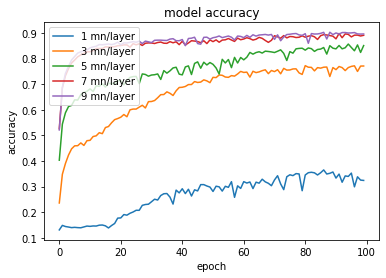

In [ ]:
names = []

for model_num in range(1,10,2):
  
  model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=1, 
                      num_metaneurons_per_layer=model_num, num_layers_per_metaneuron=3, 
                      num_neurons_per_metaneuron_layer=4, activation="relu", 
                      output_activation="softmax", residual_connections="full", use_metaneurons=True)
  
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{model_num} mn/layer")


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

In [ ]:
[layer.name for layer in model2.layers]

['input_7',
 'flatten_6',
 'dense_18',
 'dense_19',
 'dense_20',
 'dense_21',
 'dense_22',
 'dense_23',
 'dense_24',
 'dense_25',
 'dense_26',
 '0.0.in',
 '0.1.in',
 '0.2.in',
 '0.3.in',
 '0.4.in',
 '0.5.in',
 '0.6.in',
 '0.7.in',
 '0.8.in',
 '0.0.0',
 '0.1.0',
 '0.2.0',
 '0.3.0',
 '0.4.0',
 '0.5.0',
 '0.6.0',
 '0.7.0',
 '0.8.0',
 '0.0.1',
 '0.1.1',
 '0.2.1',
 '0.3.1',
 '0.4.1',
 '0.5.1',
 '0.6.1',
 '0.7.1',
 '0.8.1',
 '0.0.skip_1_to_0',
 '0.1.skip_1_to_0',
 '0.2.skip_1_to_0',
 '0.3.skip_1_to_0',
 '0.4.skip_1_to_0',
 '0.5.skip_1_to_0',
 '0.6.skip_1_to_0',
 '0.7.skip_1_to_0',
 '0.8.skip_1_to_0',
 '0.0.2',
 '0.1.2',
 '0.2.2',
 '0.3.2',
 '0.4.2',
 '0.5.2',
 '0.6.2',
 '0.7.2',
 '0.8.2',
 '0.0.skip_2_to_1',
 '0.1.skip_2_to_1',
 '0.2.skip_2_to_1',
 '0.3.skip_2_to_1',
 '0.4.skip_2_to_1',
 '0.5.skip_2_to_1',
 '0.6.skip_2_to_1',
 '0.7.skip_2_to_1',
 '0.8.skip_2_to_1',
 '0.0.out',
 '0.1.out',
 '0.2.out',
 '0.3.out',
 '0.4.out',
 '0.5.out',
 '0.6.out',
 '0.7.out',
 '0.8.out',
 '0.0.skip',
 '0.1.s

In [ ]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_6 (Flatten)            (None, 784)          0           ['input_7[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 1)            785         ['flatten_6[0][0]']              
                                                                                                  
 dense_19 (Dense)               (None, 1)            785         ['flatten_6[0][0]']              
                                                                                            

Epoch 1/100
25/25 [==============================] - 1s 16ms/step - loss: 81.4261 - accuracy: 0.2019 - val_loss: 39.9583 - val_accuracy: 0.3760
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 31.3794 - accuracy: 0.4432 - val_loss: 23.7011 - val_accuracy: 0.5080
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 20.5243 - accuracy: 0.5300 - val_loss: 16.7281 - val_accuracy: 0.5651
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 15.0695 - accuracy: 0.5682 - val_loss: 12.9923 - val_accuracy: 0.5944
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 11.6522 - accuracy: 0.6047 - val_loss: 10.0858 - val_accuracy: 0.6443
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 9.1081 - accuracy: 0.6556 - val_loss: 8.2068 - val_accuracy: 0.6963
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 7.5966 - accuracy: 0.7010 - val_loss: 7.0535 - val_accuracy: 0.7187
Ep

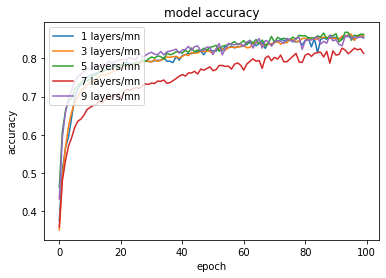

In [ ]:
names = []

for model_num in range(1,10,2):
  model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=1, 
                      num_metaneurons_per_layer=5, num_layers_per_metaneuron=model_num, 
                      num_neurons_per_metaneuron_layer=4, activation="relu", 
                      output_activation="softmax", residual_connections="full")
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{model_num} layers/mn")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

Epoch 1/100
25/25 [==============================] - 2s 20ms/step - loss: 53.7173 - accuracy: 0.2198 - val_loss: 26.7566 - val_accuracy: 0.3743
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 20.4326 - accuracy: 0.4302 - val_loss: 14.5702 - val_accuracy: 0.5121
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 12.8998 - accuracy: 0.5510 - val_loss: 10.4907 - val_accuracy: 0.6047
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 9.9016 - accuracy: 0.6103 - val_loss: 8.4912 - val_accuracy: 0.6423
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 8.1631 - accuracy: 0.6424 - val_loss: 7.1478 - val_accuracy: 0.6661
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 6.7964 - accuracy: 0.6640 - val_loss: 6.1702 - val_accuracy: 0.6838
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 6.1333 - accuracy: 0.6755 - val_loss: 5.5314 - val_accuracy: 0.6961
Epoch 

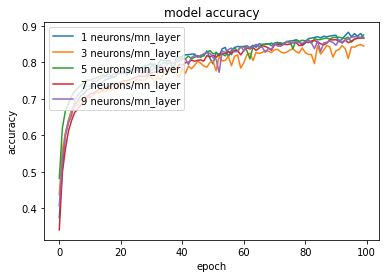

In [ ]:
names = []

for model_num in range(1,10,2):
  model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=1, 
                      num_metaneurons_per_layer=5, num_layers_per_metaneuron=3, 
                      num_neurons_per_metaneuron_layer=model_num, activation="relu", 
                      output_activation="softmax", residual_connections="full")
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{model_num} neurons/mn_layer")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

Epoch 1/100
25/25 [==============================] - 2s 20ms/step - loss: 75.9809 - accuracy: 0.1825 - val_loss: 40.4222 - val_accuracy: 0.2940
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 29.4434 - accuracy: 0.3841 - val_loss: 21.1167 - val_accuracy: 0.4557
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 17.5570 - accuracy: 0.5052 - val_loss: 14.2855 - val_accuracy: 0.5519
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 12.8696 - accuracy: 0.5774 - val_loss: 11.0796 - val_accuracy: 0.6024
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 10.2647 - accuracy: 0.6208 - val_loss: 9.0273 - val_accuracy: 0.6443
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 8.5729 - accuracy: 0.6495 - val_loss: 7.7226 - val_accuracy: 0.6715
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 7.4163 - accuracy: 0.6698 - val_loss: 6.7573 - val_accuracy: 0.6898
Epo

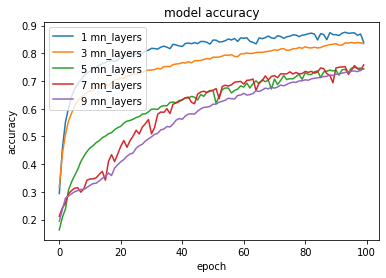

In [ ]:
names = []

for model_num in range(1,10,2):
  model2 = make_model(inp_shape=(28,28), num_outputs=10, 
                      num_metaneuron_layers=model_num, num_metaneurons_per_layer=5, 
                      num_layers_per_metaneuron=3, num_neurons_per_metaneuron_layer=4, 
                      activation="relu", output_activation="softmax", 
                      residual_connections="full")
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{model_num} mn_layers")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

In [ ]:
from keras.layers.core.dense import activations
names = []

for activation_name in ["sigmoid", "relu", "elu", "selu", "softmax"]:
  model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=1, 
                      num_metaneurons_per_layer=5, num_layers_per_metaneuron=3, 
                      num_neurons_per_metaneuron_layer=4, activation=activation_name, 
                      output_activation="softmax", residual_connections="full")
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{activation_name}")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

# Without MetaNeurons

## Comparing varying number of neurons per layer

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 2.9666 - accuracy: 0.1099 - val_loss: 2.3070 - val_accuracy: 0.1075
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 2.3023 - accuracy: 0.1103 - val_loss: 2.3025 - val_accuracy: 0.1075
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 2.3030 - accuracy: 0.1155 - val_loss: 2.3022 - val_accuracy: 0.1075
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 2.3016 - accuracy: 0.1120 - val_loss: 2.3021 - val_accuracy: 0.1075
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 2.3024 - accuracy: 0.1158 - val_loss: 2.3020 - val_accuracy: 0.1075
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 2.3013 - accuracy: 0.1143 - val_loss: 2.3020 - val_accuracy: 0.1075
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 2.3024 - accuracy: 0.1143 - val_loss: 2.3020 - val_accuracy: 0.1075
Epoch 8/100


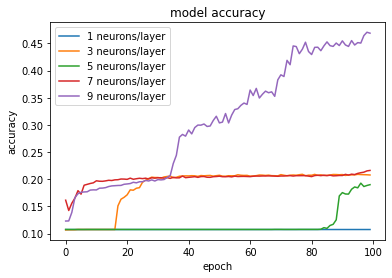

In [ ]:
names = []

for model_num in range(1,10,2):

  model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=1, 
                      num_metaneurons_per_layer=model_num, num_layers_per_metaneuron=3, 
                      num_neurons_per_metaneuron_layer=4, activation="relu", 
                      output_activation="softmax", use_metaneurons=False)
  
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{model_num} neurons/layer")


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

## Comparing varying number of model layers

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 13.7792 - accuracy: 0.0912 - val_loss: 2.3257 - val_accuracy: 0.1017
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 2.3125 - accuracy: 0.0998 - val_loss: 2.3057 - val_accuracy: 0.0949
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 2.3062 - accuracy: 0.1025 - val_loss: 2.3043 - val_accuracy: 0.1041
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 2.3093 - accuracy: 0.0996 - val_loss: 2.3036 - val_accuracy: 0.1043
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 2.3041 - accuracy: 0.1027 - val_loss: 2.3031 - val_accuracy: 0.1064
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 2.3031 - accuracy: 0.1069 - val_loss: 2.3028 - val_accuracy: 0.1077
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 2.3043 - accuracy: 0.1150 - val_loss: 2.3026 - val_accuracy: 0.1077
Epoch 8/100

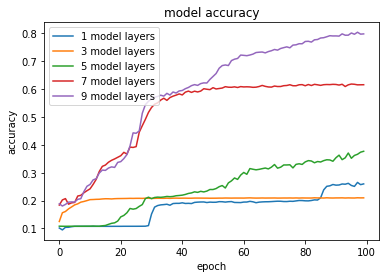

In [ ]:
names = []

for model_num in range(1,10,2):

  model2 = make_model(inp_shape=(28,28), num_outputs=10, 
                      num_metaneuron_layers=model_num, num_metaneurons_per_layer=5, 
                      num_layers_per_metaneuron=3, num_neurons_per_metaneuron_layer=4, 
                      activation="relu", output_activation="softmax", use_metaneurons=False)
  
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{model_num} model layers")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

## Comparing varying activation functions

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 2.3318 - accuracy: 0.1111 - val_loss: 2.2211 - val_accuracy: 0.1868
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 2.1688 - accuracy: 0.2164 - val_loss: 2.1077 - val_accuracy: 0.2509
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 2.0721 - accuracy: 0.2782 - val_loss: 2.0345 - val_accuracy: 0.3189
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 1.9998 - accuracy: 0.3282 - val_loss: 1.9537 - val_accuracy: 0.3251
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 1.9091 - accuracy: 0.3718 - val_loss: 1.8453 - val_accuracy: 0.4441
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 1.8164 - accuracy: 0.5133 - val_loss: 1.7698 - val_accuracy: 0.5471
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 1.7537 - accuracy: 0.5493 - val_loss: 1.7186 - val_accuracy: 0.5671
Epoch 8/100


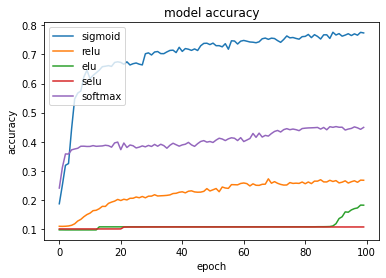

In [ ]:
names = []

for activation_name in ["sigmoid", "relu", "elu", "selu", "softmax"]:

  model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=1, 
                      num_metaneurons_per_layer=5, num_layers_per_metaneuron=3, 
                      num_neurons_per_metaneuron_layer=4, activation=activation_name, 
                      output_activation="softmax", use_metaneurons=False)
  
  model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)
  plt.plot(history2.history['val_accuracy'])
  names.append(f"{activation_name}")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(names, loc='upper left')

plt.show()

# Comparing MetaNeurons and Regular Neuron Performance

Epoch 1/100
25/25 [==============================] - 1s 22ms/step - loss: 2.2760 - accuracy: 0.1383 - val_loss: 2.2343 - val_accuracy: 0.1113
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 2.2211 - accuracy: 0.1344 - val_loss: 2.2090 - val_accuracy: 0.1861
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 2.1993 - accuracy: 0.1897 - val_loss: 2.1958 - val_accuracy: 0.1863
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 2.1917 - accuracy: 0.1834 - val_loss: 2.1842 - val_accuracy: 0.1864
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 2.1749 - accuracy: 0.1900 - val_loss: 2.1731 - val_accuracy: 0.1858
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 2.1687 - accuracy: 0.1846 - val_loss: 2.1624 - val_accuracy: 0.1879
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 2.1550 - accuracy: 0.1881 - val_loss: 2.1526 - val_accuracy: 0.1870
Epoch 8/100


KeyboardInterrupt: ignored

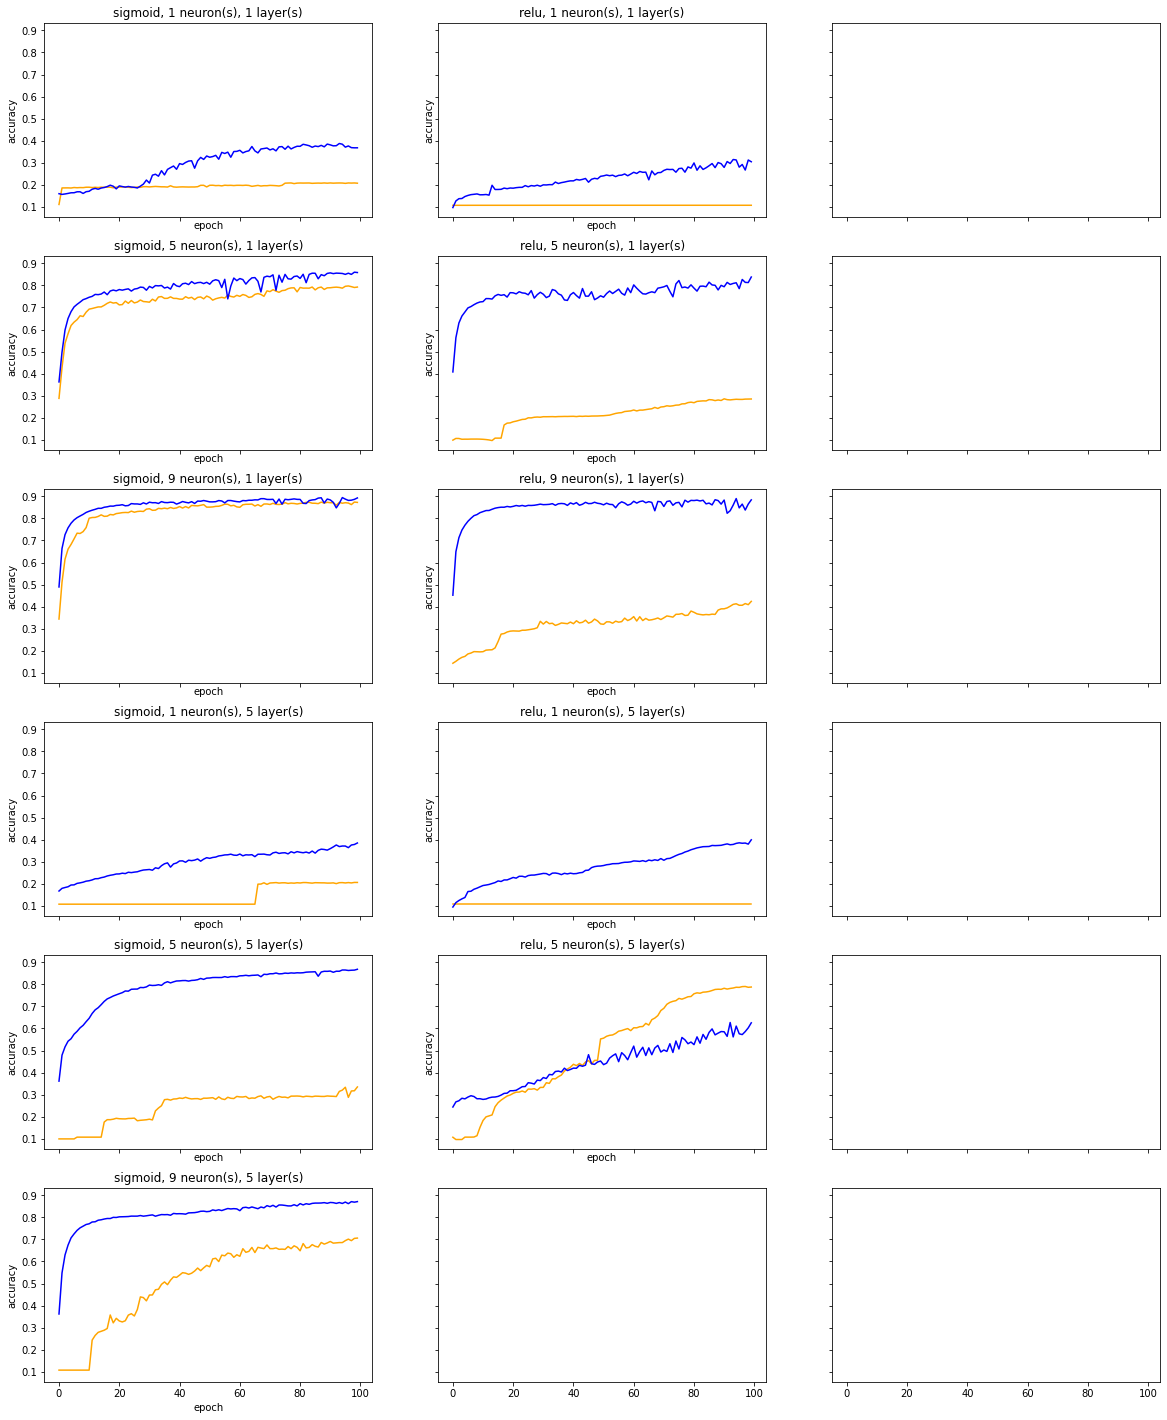

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(6, 3, figsize=(20, 25), sharex="all", sharey="all")

names = []
activations = ["sigmoid", "relu", "softmax"]


for activation_idx in range(len(activations)):
  j = 0
  for layer_count in range(1,6,4):
    for neuron_count in range(1,11,4):

      # Test regular neural networks
      model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=layer_count, 
                          num_metaneurons_per_layer=neuron_count, num_layers_per_metaneuron=5, 
                          num_neurons_per_metaneuron_layer=5, activation=activations[activation_idx], 
                          output_activation="softmax", use_metaneurons=False)
      
      model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
      history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)

      axis[j, activation_idx].plot(history2.history['val_accuracy'], color="orange")

      # Then test metaneuron neural networks with residual connections
      model2 = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=layer_count, 
                    num_metaneurons_per_layer=neuron_count, num_layers_per_metaneuron=5, 
                    num_neurons_per_metaneuron_layer=5, activation=activations[activation_idx], 
                    output_activation="softmax", use_metaneurons=True, 
                    residual_connections="full", regularize=True)
      
      model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
      history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)

      axis[j, activation_idx].plot(history2.history['val_accuracy'], color="blue")
      axis[j, activation_idx].set_title(f"{activations[activation_idx]}, {neuron_count} neuron(s), {layer_count} layer(s)")
      axis[j, activation_idx].set_ylabel('accuracy')
      axis[j, activation_idx].set_xlabel('epoch')
      
      j += 1

# plt.legend(["w_metaneuron", "wo_metaneuron"], loc='upper right')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.show()

# Visualizing Learned Activation Functions

In [ ]:
NUM_METANEURON_LAYERS = 1
NUM_METANEURONS_PER_LAYER = 3


model = make_model(inp_shape=(28,28), num_outputs=10, num_metaneuron_layers=NUM_METANEURON_LAYERS, 
                    num_metaneurons_per_layer=NUM_METANEURONS_PER_LAYER, num_layers_per_metaneuron=1, 
                    num_neurons_per_metaneuron_layer=5, activation="relu", 
                    output_activation="softmax", residual_connections="full", 
                    use_metaneurons=True)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=100, batch_size=1024, shuffle=True, validation_split=.25, steps_per_epoch=25)

Epoch 1/100
25/25 [==============================] - 1s 14ms/step - loss: 43.9779 - accuracy: 0.2494 - val_loss: 25.1657 - val_accuracy: 0.3606
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 20.2452 - accuracy: 0.3837 - val_loss: 15.7714 - val_accuracy: 0.4086
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 13.6205 - accuracy: 0.4333 - val_loss: 11.6806 - val_accuracy: 0.4507
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 10.3346 - accuracy: 0.4628 - val_loss: 9.2721 - val_accuracy: 0.4859
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 8.5365 - accuracy: 0.4983 - val_loss: 7.6935 - val_accuracy: 0.5131
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 7.1718 - accuracy: 0.5239 - val_loss: 6.5568 - val_accuracy: 0.5288
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 6.1441 - accuracy: 0.5379 - val_loss: 5.7266 - val_accuracy: 0.5477
Epoch

In [ ]:
model.summary()

Model: "model_159"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_115 (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_69 (Flatten)           (None, 784)          0           ['input_115[0][0]']              
                                                                                                  
 dense_493 (Dense)              (None, 1)            785         ['flatten_69[0][0]']             
                                                                                                  
 dense_494 (Dense)              (None, 1)            785         ['flatten_69[0][0]']             
                                                                                          

MetaNeuron 1, Layer 1
1875/1875 [==============================] - 2s 1ms/step
MetaNeuron 2, Layer 1
1875/1875 [==============================] - 2s 1ms/step
MetaNeuron 3, Layer 1
1875/1875 [==============================] - 2s 1ms/step


[]

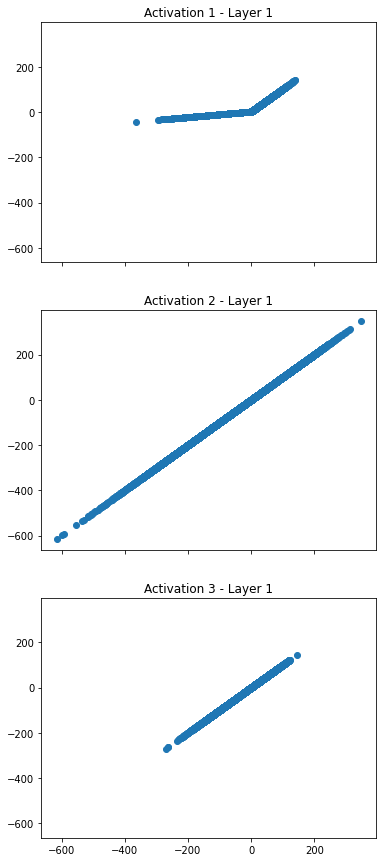

In [ ]:
figure, axis = plt.subplots(NUM_METANEURONS_PER_LAYER, NUM_METANEURON_LAYERS, 
                            figsize=(2*NUM_METANEURONS_PER_LAYER, 15*NUM_METANEURON_LAYERS), 
                            sharex="all", sharey="all")

for i in range(NUM_METANEURON_LAYERS):
  for j in range(NUM_METANEURONS_PER_LAYER):

    print(f"MetaNeuron {j + 1}, Layer {i + 1}")


    # if i == 0:

    metaneuron_inp = Model(model.input, 
                          model.get_layer(f"{i}.{j}.in").input)

    metaneuron_out = Model(model.get_layer(f"{i}.{j}.in").input, 
                          model.get_layer(f"{i}.{j}.skip").output)

    minp = metaneuron_inp.predict(x_train)
    mout = metaneuron_out.predict(minp)

    if NUM_METANEURON_LAYERS != 1:

      axis[j, i].scatter(x = list(minp), y = list(mout))
      axis[j, i].set_title(f"Activation {j + 1} - Layer {i + 1}")

    elif NUM_METANEURON_LAYERS == 1:
      axis[j].scatter(x = list(minp), y = list(mout))
      axis[j].set_title(f"Activation {j + 1} - Layer {i + 1}")      

plt.plot()